In [1]:
from modules import conv_block, separable_conv_block,conv_transpose, out_sep_conv_block
from u_encoder_64 import U_Encoder
from U_decoder_64 import U_Decoder
from weights import gaussian_neighbor, intensity, RAG, normalized_cuts, reconstruction_loss
#from n_cuts import 


import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import time

import cv2
import PIL
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
from scipy import ndimage, misc

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
seed = 42
np.random.seed = seed

BATCH_SIZE = 3
EPOCHS = 25
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_CHANNELS = 3
#classes = 5
MSE = tf.keras.losses.MeanSquaredError()
X_train = np.load('X_train.npy') 
images = X_train[[210,330, 434]]





In [3]:
MSE

In [4]:
factor = 1.3
for i in range(3):
  im_pil = Image.fromarray(images[i])
  enhancer = ImageEnhance.Contrast(im_pil)
  im_pik = enhancer.enhance(factor)
  images[i] = np.array(im_pik)


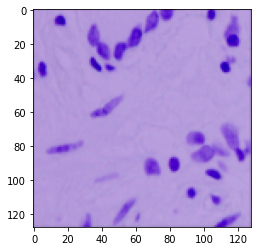

In [5]:
plt.imshow(images[2])

In [6]:

images=images.astype('float32') /255


In [7]:

img0 = cv2.resize(images[0], dsize = (96,64))
img1 = cv2.resize(images[1], dsize = (96,64))
img2 = cv2.resize(images[2], dsize = (96,64))

imgs = np.array([img0, img1, img2])

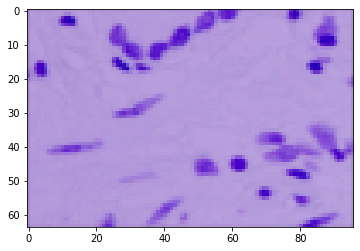

In [8]:
plt.imshow(imgs[2])

In [10]:
#stime = time.time()
classes = 3


encoder = U_Encoder(classes, activation = 'softmax')
decoder = U_Decoder(num_channels = 3, activation = 'linear')


encoder.build((None,64 ,96,3))
decoder.build((None,64 ,96,classes))

encoder.summary()
decoder.summary()



2022-02-06 19:13:15.020575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-06 19:13:15.021151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "u__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_block (conv_block)      multiple                  2832      
_________________________________________________________________
separable_conv_block (separa multiple                  2160      
_________________________________________________________________
out_sep_conv_block (out_sep_ multiple                  7392      
_________________________________________________________________
conv_transpose (conv_transpo multiple                  12352     
_________________________________________________________________
conv_transpose_1 (conv_trans multiple                  3360      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  51        
Total params: 28,147
Trainable params: 27,827
Non-trainable params: 320
____________________

In [11]:
#@tf.function
def train_step(X_batch,graph_spatial):
    #print("Batch ", X_batch.shape)
    loss_ns = []
    loss_rc = []
    with tf.GradientTape(persistent = True) as tape:
        out_enc = encoder(X_batch)
        out_dec = decoder(out_enc)
        out_enc = tf.reshape(out_enc, (out_enc.shape[0],-1,out_enc.shape[3]))
        print("Encoder Output shape ", out_enc.shape)
        data_ncuts = (X_batch, out_enc)
       # print("Calculating Loss")
        start2 = time.time()
      
        ncuts_loss =tf.map_fn(lambda x: normalized_cuts(x[0], x[1], classes, graph_spatial , sigma_I=10), data_ncuts, fn_output_signature= tf.float32, parallel_iterations = 32)
        ncuts_loss = tf.math.reduce_mean(ncuts_loss)
        loss_ns.append(ncuts_loss)
        #ncuts_loss = batch_normalized_cuts(X_batch, out_enc, 2, graph_spatial , sigma_I=10)
        print(" Ncuts loss is ", ncuts_loss)
    
        recon_loss = reconstruction_loss(MSE, out_dec, X_batch)
        loss_rc.append(recon_loss)
        print(" Reconstruction loss is  ", recon_loss)
    
    
       
        
        
    
    print("calculating Gradient")
    grads_ncuts = tape.gradient(ncuts_loss, encoder.trainable_variables)

    grads_recon = tape.gradient(recon_loss, encoder.trainable_variables)
    #print(tf.trainable_variables())
    grads = grads_ncuts+grads_recon
    #optimizer.apply_gradients(zip(grads_ncuts, encoder.trainable_variables))
    
    optimizer.apply_gradients(zip(grads, encoder.trainable_variables))
    
    grads_recon = tape.gradient(recon_loss, decoder.trainable_variables)
    optimizer.apply_gradients(zip(grads_recon, decoder.trainable_variables))
    
    print("Time Taken to calculate loss for whole batch is ", time.time()-start2, " seconds")
    return loss_ns, loss_rc


In [54]:
#num_updates = int(X_train.shape[0]/BATCH_SIZE )
#num_updates = 30 
EPOCHS = 150
classes = 2
lr = 0.003
loss_cuts = []
loss_recon = []

#graph_spatial = gaussian_neighbor(X_train.shape[1], X_train.shape[2],radius=5, sigma_x=4) #CELL
graph_spatial = gaussian_neighbor(imgs.shape[1], imgs.shape[2],radius=5, sigma_x=4) #derma
for epoch in range(1, EPOCHS+1):
   
    if epoch % 50 == 0 :
       
       lr = lr*0.75
       print("LEARNING RATE IS CHANGED ", lr)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    print("[INFO] starting Epoch {}/{}...".format(epoch , EPOCHS), end="")
    epochStart = time.time()
    for i in range(0, 1):
    # determine starting and ending slice indexes for the current
    # batch
        print("Update number ", i)
        #start = i * BATCH_SIZE 
        #end = start + BATCH_SIZE 
    # take a step
        #weights = RAG(X_train[start:end])
        #train_loss = train_step(X_train[start:end], graph_spatial)
        #ls_ns, ls_rc= train_step(X_train, graph_spatial) #Cell Images
        ls_ns, ls_rc= train_step(imgs, graph_spatial) # derma image
        loss_cuts.append(ls_ns)
        loss_recon.append(ls_rc)
        
    if epoch %10 == 0:
      encoder.save_weights('encoder_3_10_'+str(epoch)+'.h5')
      decoder.save_weights('decoder_3_10_'+str(epoch)+'.h5')


    epochEnd = time.time()
    elapsed = (epochEnd - epochStart) / 60.0
    print("Epoch {}/{} took {:.4} minutes".format(epoch + 1, EPOCHS, elapsed))
#model.compile(optimizer=optimizer, loss=custom_loss, metrics=["acc"])

#callbacks  = [keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'), 
              #keras.callbacks.TensorBoard(log_dir= '/Users/mariam/Desktop/Leiden_Courses/Research/Code/Unet/Unet_Wnet/logs')]

graph shape  (6144, 6144)
Runtime of obtaining gaussian Neighbor is  0.4524111747741699  seconds
[INFO] starting Epoch 1/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(1.0027516, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.01418949, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  6.244268178939819  seconds
Epoch 2/150 took 0.1052 minutes
[INFO] starting Epoch 2/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.97706294, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.027595673, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.6113481521606445  seconds
Epoch 3/150 took 0.1282 minutes
[INFO] starting Epoch 3/150...Update number  0
Encoder Output shap

Time Taken to calculate loss for whole batch is  6.938992023468018  seconds
Epoch 21/150 took 0.1175 minutes
[INFO] starting Epoch 21/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.4340415, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.01400081, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.308609962463379  seconds
Epoch 22/150 took 0.1227 minutes
[INFO] starting Epoch 22/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.35875005, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.023844263, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.167314767837524  seconds
Epoch 23/150 took 0.1209 minutes
[INFO] starting Epoch 23/150...Update number  0
Enc

Time Taken to calculate loss for whole batch is  157.97523617744446  seconds
Epoch 41/150 took 2.636 minutes
[INFO] starting Epoch 41/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.15086523, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.019366171, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  7.239919900894165  seconds
Epoch 42/150 took 0.1214 minutes
[INFO] starting Epoch 42/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.761212, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.033788517, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  8.001790046691895  seconds
Epoch 43/150 took 0.1343 minutes
[INFO] starting Epoch 43/150...Update number  0
Enc

 Ncuts loss is  tf.Tensor(0.13567013, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.018485948, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  4.8507373332977295  seconds
Epoch 61/150 took 0.08385 minutes
[INFO] starting Epoch 61/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.11332586, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.011909342, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.862730026245117  seconds
Epoch 62/150 took 0.06589 minutes
[INFO] starting Epoch 62/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.1265918, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss i

Time Taken to calculate loss for whole batch is  4.008021116256714  seconds
Epoch 80/150 took 0.06833 minutes
[INFO] starting Epoch 80/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.35399526, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.017765956, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.697920083999634  seconds
Epoch 81/150 took 0.06436 minutes
[INFO] starting Epoch 81/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.75803614, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.01428417, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.6169378757476807  seconds
Epoch 82/150 took 0.06148 minutes
[INFO] starting Epoch 82/150...Update number  

 Ncuts loss is  tf.Tensor(0.28222305, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.013204061, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.4772257804870605  seconds
Epoch 100/150 took 0.05971 minutes
LEARNING RATE IS CHANGED  0.0016875000000000002
[INFO] starting Epoch 100/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.09254917, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.011996819, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.158947706222534  seconds
Epoch 101/150 took 0.05461 minutes
[INFO] starting Epoch 101/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.354246, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python

Time Taken to calculate loss for whole batch is  3.403463125228882  seconds
Epoch 119/150 took 0.05756 minutes
[INFO] starting Epoch 119/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.28774747, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.009929088, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.504995107650757  seconds
Epoch 120/150 took 0.06005 minutes
[INFO] starting Epoch 120/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.31875944, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.01453225, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.2323501110076904  seconds
Epoch 121/150 took 0.05574 minutes
[INFO] starting Epoch 121/150...Update nu

 Ncuts loss is  tf.Tensor(0.09617345, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.013611204, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.171800136566162  seconds
Epoch 139/150 took 0.0538 minutes
[INFO] starting Epoch 139/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.09992596, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction loss is   tf.Tensor(0.009420635, shape=(), dtype=float32)
calculating Gradient
Time Taken to calculate loss for whole batch is  3.1052298545837402  seconds
Epoch 140/150 took 0.05256 minutes
[INFO] starting Epoch 140/150...Update number  0
Encoder Output shape  (3, 6144, 3)
 Ncuts loss is  tf.Tensor(0.09195145, shape=(), dtype=float32)
prediction type  <class 'tensorflow.python.framework.ops.EagerTensor'>
 Reconstruction lo

In [18]:
np.save("loss_ncuts.npy", loss_cuts)
np.save("loss_recon.npy", loss_recon)



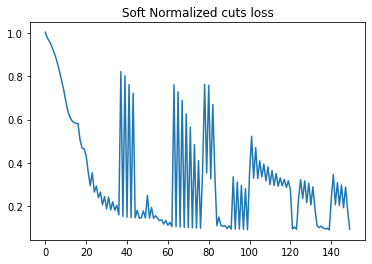

In [55]:
plt.title('Soft Normalized cuts loss')
plt.plot(loss_cuts)

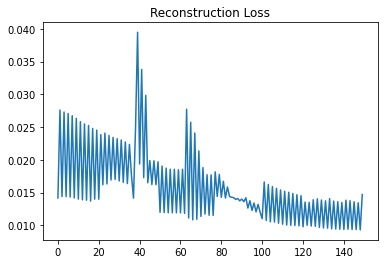

In [56]:
plt.title('Reconstruction Loss')
plt.plot(loss_recon)